In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data
df = pd.read_csv("xy_data.csv")
print(f"Data loaded. N = {len(df)}")
print(df.head(), "\n")


def model_xy(t_values, theta_deg, M, X_offset):
    theta = np.deg2rad(theta_deg) 
    t = np.asarray(t_values)

    exp_term = np.exp(M * np.abs(t))
    x_pred = t * np.cos(theta) - exp_term * np.sin(0.3 * t) * np.sin(theta) + X_offset
    y_pred = 42.0 + t * np.sin(theta) + exp_term * np.sin(0.3 * t) * np.cos(theta)

    return x_pred, y_pred


def l1_loss(params, t_values, x_obs, y_obs):
    theta_deg, M, X_offset = params
    x_pred, y_pred = model_xy(t_values, theta_deg, M, X_offset)
    return np.sum(np.abs(x_obs - x_pred) + np.abs(y_obs - y_pred))


def fit_curve(x_data, y_data):
    N = len(x_data)
    
    # Generate t values (from 6 to 60)
    t = 6.0 + (np.arange(N) / (N - 1.0)) * (60.0 - 6.0)

    # Step 1: Coarse grid search for initial guess
    theta_values = np.linspace(1, 49, 10)
    M_values = np.linspace(-0.045, 0.045, 9)

    best_params = None
    best_loss = 1e30

    for theta in theta_values:
        for M in M_values:
            x_tmp, y_tmp = model_xy(t, theta, M, 0.0)
            X_est = np.mean(x_data - x_tmp)
            X_est = float(np.clip(X_est, 0.0, 100.0))
            loss_value = l1_loss((theta, M, X_est), t, x_data, y_data)

            if loss_value < best_loss:
                best_loss = loss_value
                best_params = (theta, M, X_est)

    init_guess = list(best_params)

    # Step 2: Local optimization using L-BFGS-B
    bounds = [
        (1e-6, 50 - 1e-6),       
        (-0.05 + 1e-8, 0.05 - 1e-8),
        (0.0 + 1e-8, 100.0 - 1e-8)  
    ]

    result = minimize(
        lambda p: l1_loss(p, t, x_data, y_data),
        x0=init_guess,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 10000, 'ftol': 1e-9}
    )

    theta_opt, M_opt, X_opt = result.x
    total_L1 = result.fun
    avg_L1 = total_L1 / N

    print(f"Theta = {theta_opt:.4f}°")
    print(f"M = {M_opt:.6f}")
    print(f"X = {X_opt:.4f}")
    print(f"Total L1 = {total_L1:.4f}, Average L1 = {avg_L1:.4f}\n")

    t_fine = np.linspace(6, 60, 2000)
    x_fit, y_fit = model_xy(t_fine, theta_opt, M_opt, X_opt)

    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, s=6, alpha=0.6, label='Data')
    plt.plot(x_fit, y_fit, linewidth=2, color='orange', label='Fitted Model')
    plt.axis('equal')
    plt.legend()
    plt.title(f"X-sorting → θ={theta_opt:.3f}°, M={M_opt:.6f}, X={X_opt:.3f}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    return total_L1, avg_L1, (theta_opt, M_opt, X_opt)


Data loaded. N = 1500
            x          y
0   88.364456  57.784378
1   74.283936  54.406780
2   60.256474  46.311462
3   82.134370  57.717567
4  101.036390  67.849340 



Theta = 30.0436°
M = 0.029991
X = 55.0155
Total L1 = 453.4369, Average L1 = 0.3023



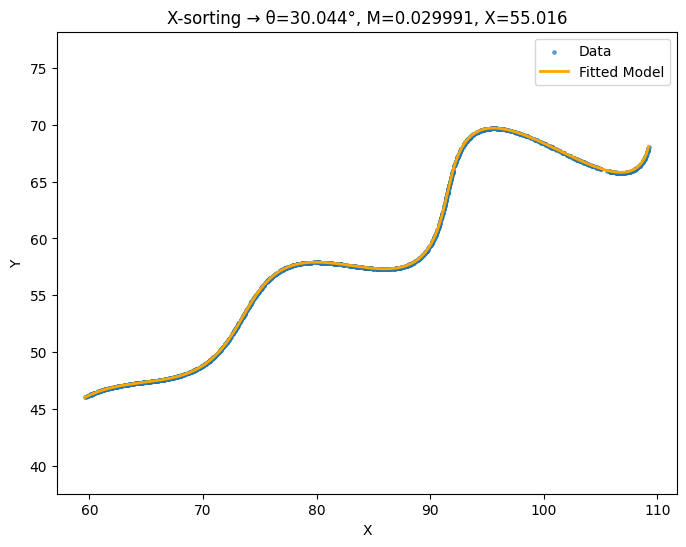

In [10]:

df_x = df.sort_values(by='x')
xs_x, ys_x = df_x['x'].values, df_x['y'].values

total_l1, avg_l1, (theta_opt, M_opt, X_opt) = fit_curve(xs_x, ys_x)

